### 코로나 데이터로 NAN_temp_df를 사용하는 ARIMAX 코드

다음과 같은 사전 작업이 완료되어야 함

1. TI(기술적 지표, 이동평균, 차분 등) 칼럼에 추가한 etf_name_TI.csv 파일 생성
2. NAN_temp_df 내의 결측치 모두 처리 : fill 하든 drop 하든

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### 데이터 로드

In [ ]:
corona_data = 'NAN_temp_df.csv' #드라이브 마운트 해서 할 거면 경로 복사해서 하기
etf_data = #'TIGER_반도체_TI.csv'  #이건 Add TI_column 으로 TI 변수 추가한 후에 가능함

corona_df = pd.read_csv(corona_data, index_col = 0)
etf_df = pd.read_csv(etf_data)
#corona_df.head()
#etf_df.head()

,stateDt,decideCnt,clearCnt,examCnt,deathCnt,careCnt,resutlNegCnt,accExamCnt,accExamCompCnt,accDefRate
0,20230420,31039863.0,NaN,NaN,34401.0,NaN,NaN,NaN,NaN,NaN
1,20230419,31025769.0,NaN,NaN,34392.0,NaN,NaN,NaN,NaN,NaN
2,20230418,31009261.0,NaN,NaN,34386.0,NaN,NaN,NaN,NaN,NaN
3,20230417,30994088.0,NaN,NaN,34376.0,NaN,NaN,NaN,NaN,NaN
4,20230415,30978954.0,NaN,NaN,34368.0,NaN,NaN,NaN,NaN,NaN


#### 두 데이터의 날짜 형식 통일

In [ ]:
# tiger_etf의 '날짜' 컬럼을 datetime 유형으로 확인 또는 변환
etf_df['날짜'] = pd.to_datetime(etf_df['날짜'])

etf_df['날짜_int'] = etf_df['날짜'].dt.strftime('%Y%m%d').astype(int)

# 데이터 병합 시도
merged_data = pd.merge(left=corona_df, right=etf_df, left_on='stateDt', right_on='날짜_int', how='inner')

# 필요한 열만 선택
#merged_data = merged_data[['stateDt', 'decideCnt', '종가']]  #딱히 안 해도 됨

# 날짜로 정렬
merged_data = merged_data.sort_values(by='stateDt')

# 결과 확인
merged_data.head()


,stateDt,decideCnt,종가
770,20200203,15.0,26470.0
769,20200204,19.0,26995.0
768,20200205,19.0,26980.0
767,20200206,23.0,27350.0
766,20200207,24.0,27105.0


#### 결측치 확인

In [ ]:
merged_data.isnull().sum()

stateDt             0
decideCnt           0
종가                  0
decideCnt_change    0
종가_change           0
dtype: int64

#### PMDArima 라이브러리 설치

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.3 MB/s eta 0:00:00


#### auto_arima로 최적의 p,d,q,s 찾기

In [ ]:
from pmdarima import auto_arima

target_data =  merged_data['diff_5']  #얘도 실제 타깃 데이터로 하면 됨, 일단 5일 차분으로 해 놓음
exog_data = merged_data#[실제 외생변수 칼럼]

print(f"Processing...")
try:
    # auto_arima 실행
    auto_arima_model = auto_arima(target_data, exogeneous = exog_data, start_p=0, start_q=0,
                                  start_d = 0, max_p=5, max_d = 2, max_q=5, seasonal=False,
                                  trace=True, error_action='ignore',
                                  suppress_warnings=True)
    # 최적 파라미터 저장
    optimal_params= (auto_arima_model.order, auto_arima_model.seasonal_order)
    print(f"Optimal parameters: {auto_arima_model.order}, Seasonal Order: {auto_arima_model.seasonal_order}")
except Exception as e:
    print(f"An error occurred while processing: {e}")

# 최적 파라미터 출력
print("Optimal ARIMA parameters for the column:")
for params in optimal_params:
    print(f": ARIMA{params[0]}, Seasonal Order: {params[1]}")


Processing...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2593.712, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-3369.297, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-3050.044, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-3379.893, Time=0.15 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-3397.009, Time=0.19 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-3406.517, Time=0.26 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=-3417.774, Time=0.23 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=-3473.619, Time=1.18 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-3406.394, Time=0.82 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=-3519.447, Time=2.25 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=-3399.560, Time=1.64 sec
 ARIMA(5,0,3)(0,0,0)[0]             : AIC=-3599.339, Time=1.42 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=-3527.924, Time=1.22 sec
 ARIMA(5,0,4)(0,0,0)[0]             : AIC=inf, Time=1.94 sec
 ARIMA(4,0,

#### 위에서 구한 최적의 파라미터로 ARIMAX 모델 학습

In [ ]:
# SARIMAX 모델 적합 및 결과 요약 출력을 위한 수정된 코드
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ARIMAX 모델 적합
model = SARIMAX(target_data,
                order=auto_arima_model.order,
                exog=exog_data,
                enforce_stationarity=True,
                enforce_invertibility=True)

# 모델 학습
results = model.fit()

results_summary = results.summary()

# 결과를 문자열로 변환하여 라인별로 처리 가능하게 만듦
results_str = str(results_summary)
print(results_str)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              종가_change   No. Observations:                  771
Model:               SARIMAX(5, 0, 3)   Log Likelihood                1806.215
Date:                Tue, 02 Apr 2024   AIC                          -3592.431
Time:                        14:31:41   BIC                          -3545.954
Sample:                             0   HQIC                         -3574.545
                                - 771                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
decideCnt_change  5.694e-05      0.000      0.169      0.866      -0.001       0.001
ar.L1                0.4876      0.041     11.831      0.000       0.407       0.568
ar.L2                0.0955 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### 모델로 예측한 값 칼럼 추가

In [ ]:
# 모델에서 예측값 생성
# 학습 데이터에 대한 "in-sample" 예측을 위해, 예측 기간의 exog 데이터로 학습에 사용된 것과 같은 데이터를 사용합니다.
predicted_change = results.predict(start=0, end=len(merged_data)-1, exog=exog_data)

# 예측값을 데이터프레임에 추가
merged_data['predicted_change'] = predicted_change
merged_data['stateDt'] = merged_data['stateDt'].astype(str)

merged_data

,stateDt,decideCnt,종가,decideCnt_change,종가_change,predicted_change
770,20200203,15.0,26470.0,0.266667,0.019834,-0.001427
769,20200204,19.0,26995.0,0.266667,0.019834,0.030464
768,20200205,19.0,26980.0,0.000000,-0.000556,0.021261
767,20200206,23.0,27350.0,0.210526,0.013714,-0.008673
766,20200207,24.0,27105.0,0.043478,-0.008958,0.002688
...,...,...,...,...,...,...
4,20230414,30967692.0,29860.0,0.000377,-0.005164,-0.000539
3,20230417,30994088.0,29775.0,0.000852,-0.002847,-0.006969
2,20230418,31009261.0,29260.0,0.000490,-0.017296,-0.007160
1,20230419,31025769.0,29325.0,0.000532,0.002221,-0.007799


#### 결과 시각화

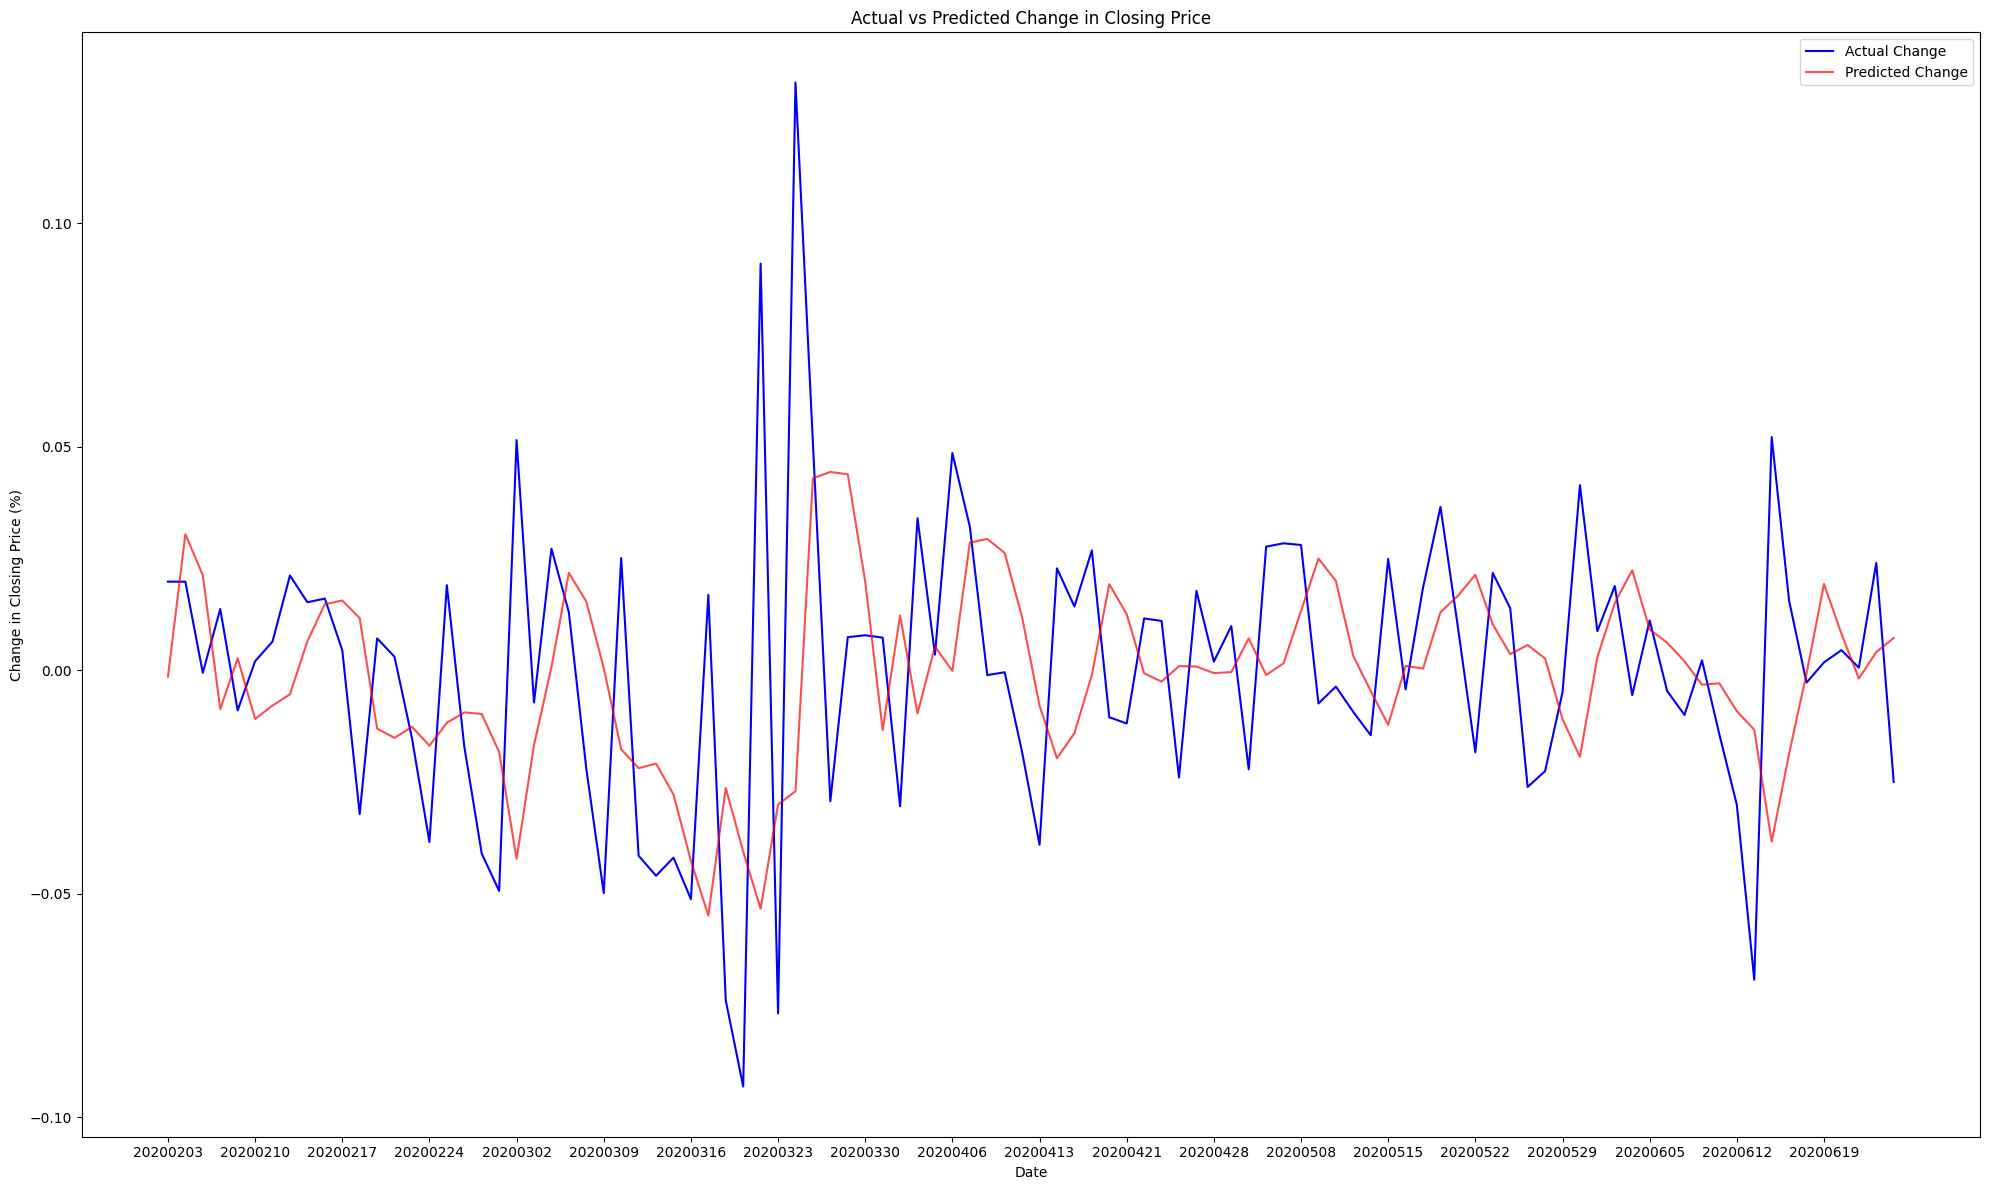

In [ ]:
# 실제 종가 변화율과 예측된 변화율을 시각화합니다.
plt.figure(figsize=(20, 12))
plt.plot(merged_data['stateDt'].iloc[:100], target_data.iloc[:100], label='Actual Change', color='blue')
plt.plot(merged_data['stateDt'].iloc[:100], exog_data.iloc[:100], label='Predicted Change', color='red', alpha=0.7)
plt.title('Actual vs Predicted Change in Closing Price')
plt.xlabel('Date')
plt.ylabel('Change in Closing Price (%)')
plt.xticks(merged_data['stateDt'].iloc[:100][::5])
plt.tight_layout()
plt.legend()
plt.show()
